# CHASM (CHerenkov Air Shower Model) Demo
## Hypothetical Tau Primary Upward Air Shower
This notebook shows how to use the CHASM program to simulate the Cerenkov light profile of an air shower using universality. First import some stuff we'll need, including CHASM itself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CHASM.simulation import *

Now we need to define our array of telescopes. These need to be ahead of the shower to see any Cherenkov light. The origin of the CHASM coordinate system is where the shower axis intersects with Earth's surface. The z axis is vertical from that point, x axis is north, and y axis is west. It is convenient to define the shower axis using spherical coordinates, where we use the standard physics convention (theta is the polar angle measured down from the z axis). 

In this case, we will be simulating an tau primary air shower (upward going) from the charged-current decay of an Earth skimming tau neutrino. We want to simulate detectors in orbit, ~500 km above Earth's surface, which corresponds to ~2000 km along an axis with an 85 degree polar angle (see figure below). We create an array of detectors perpendicular to the shower axis (arrayed on the y axis) at this point in space.

In [2]:
r = 2141673
theta = np.radians(85)
arc = np.radians(2)
phi = 0
Nxc = 12
Nyc = 12

phis = np.linspace(-arc,arc,Nxc)
thetas = np.linspace(theta-arc,theta+arc,Nyc)
counters = np.empty([Nxc*Nyc,3])
theta_tel, phi_tel = np.meshgrid(thetas,phis)

counters[:,0] = r * np.sin(theta_tel.flatten()) * np.cos(phi_tel.flatten())
counters[:,1] = r * np.sin(theta_tel.flatten()) * np.sin(phi_tel.flatten())
counters[:,2] = r * np.cos(theta_tel.flatten())

First we instantiate the simulation:

In [3]:
sim = ShowerSimulation()

Now we can add things to the simulation using the sim.add() method. First we'll add an axis using the same theta and phi we used to place the array of orbital counters. Since this is an upward shower, we add an upward axis. Since the zenith angle is large (>60 degrees) we must use a curved atmosphere.

In [4]:
sim.add(UpwardAxis(theta,phi,curved=True))

Now we need a shower. In this example we're using a shower defined by Gaisser (RIP) Hillas parameters. The first argument is X_max, the second is N_max, the third is X_0, and the fourth is Lambda. Alternatively, one could add a shower defined by an array of shower sizes at an array of corresponding depths.

In [5]:
sim.add(GHShower(666.,6e7,0.,70.))

Now we add our counters. They must be an array of cartesian vectors. The second argument is the surface area of a telescope's aperture in meters squared.

In [6]:
sim.add(SphericalCounters(counters, 1.))

Finally, we need to define the Cherenkov wavelength interval accepted by the detectors. The first argument is the minimum Cherenkov wavelength in nanometers, the second is the maximum.

In [7]:
sim.add(Yield(300,450))

Now we can run, creating the objects which store the actual Cherenkov signals.

In [8]:
sim.run(mesh=True)

Let's plot the Cherenkov signal at the counters.

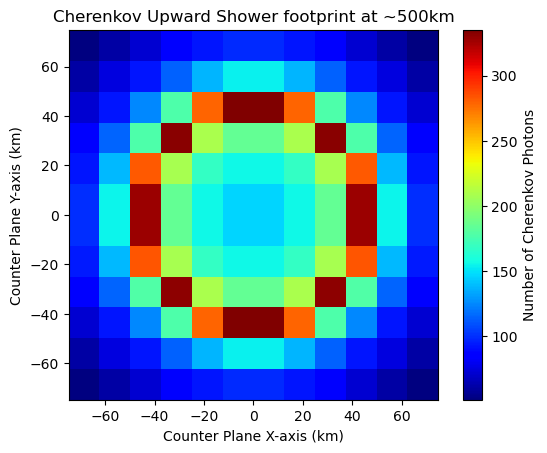

In [9]:
fig = plt.figure()
cx = r*phi_tel.flatten()*1.e-3
cy = r*theta_tel.flatten()*1.e-3
h2d = plt.hist2d(cx,cy-np.median(cy),weights=sim.get_signal_sum(),bins=Nxc, cmap=plt.cm.jet)
plt.title('Cherenkov Upward Shower footprint at ~500km')
plt.xlabel('Counter Plane X-axis (km)')
plt.ylabel('Counter Plane Y-axis (km)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')

Text(0.5, 1.0, 'Effect of Arrival Time Correction')

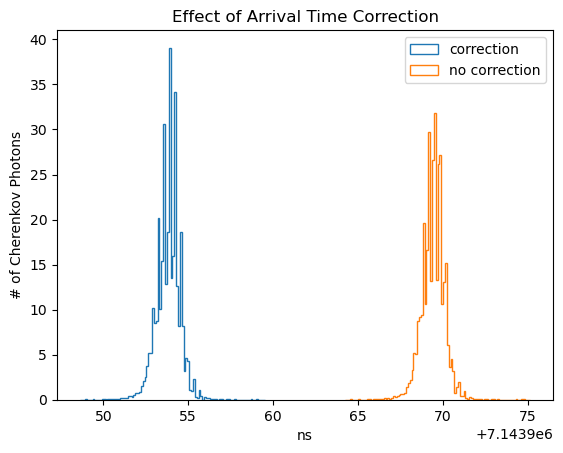

In [10]:
plt.figure()

all_times, all_photons = sim.get_signal_times()
imax = sim.get_signal_sum().argmax()
times = all_times[imax]
photons = all_photons[imax]
i = photons > .01

ha = plt.hist(times[i],100, weights=photons[i], histtype='step',label='correction')

sim.remove('axis')
sim.add(UpwardAxis(theta,phi,curved=False))
sim.run(mesh=True)
all_times, all_photons = sim.get_signal_times()
imax = sim.get_signal_sum().argmax()
times = all_times[imax]
photons = all_photons[imax]
i = photons > .01

hb = plt.hist(times[i],100, weights=photons[i], histtype='step',label='no correction')

plt.xlabel('ns')
plt.ylabel('# of Cherenkov Photons')
plt.legend()
plt.title('Effect of Arrival Time Correction')


In [11]:
all_photons.shape

(144, 280001)

(-100000.0, 1000000.0)

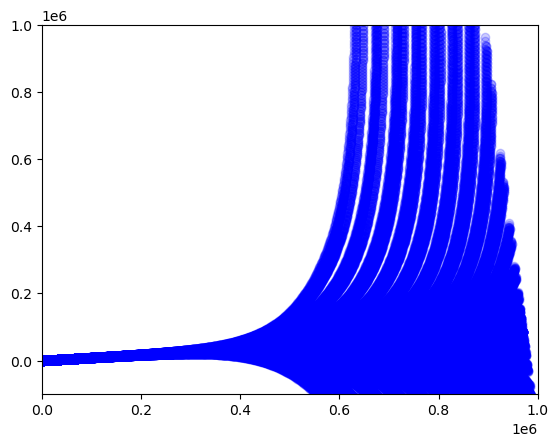

In [12]:
fig = plt.figure()
for s in sim.signals[:,0]:
    plt.scatter(s.axis.vectors[:,0],s.axis.vectors[:,2],c='b', alpha=0.2)
plt.xlim(0,1.e6)
plt.ylim(-.1e6,1.e6)